In [127]:
from importlib import reload
import pygsti
import qubic.job_manager_jpm as job_manager
from pygsti.models import modelconstruction as _mc
from matplotlib import pyplot as plt
from qubic.state_disc import GMMManager
from distproc.hwconfig import FPGAConfig, load_channel_configs
import chipcalibration.config as cfg
import qubic.rpc_client as rc
import chipcalibration.repeated_xgates as _xgate

In [128]:
reload(job_manager)
reload(_xgate)

<module 'chipcalibration.repeated_xgates' from '/home/jpmarceaux/PycharmProjects/chipcalibration/chipcalibration/repeated_xgates.py'>

In [129]:
register = ['Q1']  # these correspond to the actual qubit id's on the qubic device
gate_names = ['Gxpi2', 'Gzpi2']

availability = {
    'Gxpi2': [(qid,) for qid in register],
    'Gzpi2': [(qid,) for qid in register],
}

pspec = pygsti.processors.QubitProcessorSpec(num_qubits=len(register), gate_names=gate_names,
                                             availability=availability, qubit_labels=register)

# make a pygsti simulation manager
model = _mc.create_explicit_model(pspec)
model.set_all_parameterizations('TP')
model = model.depolarize(0.01)
sim_manager = job_manager.SimulationManager(model, readout_register=['Q1'])


In [130]:
xreps = _xgate.XGateRepetition(register, ['Q1'], 0.1, 0.05, 20)

1

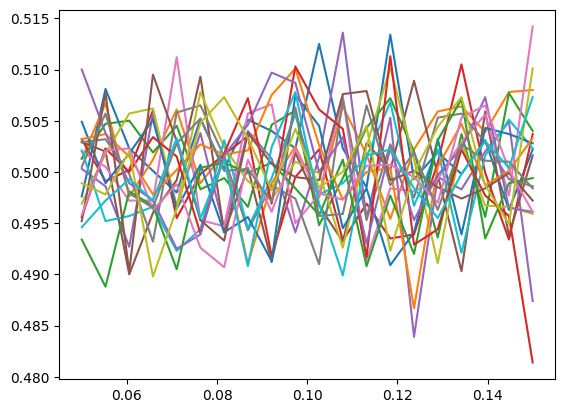

In [131]:
xreps.run_and_report(sim_manager, 10000, None)